- Test the robustness of findings under different high-risk group sizes: illegal_prob=10^{-2,-1,1}; half-life=2 day; network of 10^5 nodes
- Reproduce Fig.4 in the paper 

In [1]:
import simsom.utils as utils
import numpy as np
import pandas as pd
import os
import glob

## Helpers

In [2]:
def get_agg_metric(
    df,
    group_key="base_name",
    new_col_prefix="baseline",
    metrics=[
        "quality",
        "illegal_frac",
        "unique_illegal_frac",
        "illegal_count",
        "unique_illegal_count",
    ],
    retain_keys=["illegal_prob"],
):
    """
    Return a df where the columns of interest are aggregated by mean and std & renamed (prefix with a phrase)
    new_col_prefix (str): the prefix to append to aggregated cols
    """
    if any(i not in df.columns for i in retain_keys):
        raise ValueError(
            "retain_keys, e.g., `illegal_prob` column not found in the dataframe. This is needed as a dummy column to count the number of observations."
        )
    for metric in metrics:
        df[f"{metric}_std"] = df[metric]
        df = df.rename(columns={metric: f"{metric}_mean"})

    # aggregate (by mean or std)
    agg = dict()
    for col in retain_keys:
        if col == "illegal_prob":
            agg[col] = "count"
        else:
            agg[col] = "first"
    for metric in metrics:
        agg[f"{metric}_mean"] = "mean"
        agg[f"{metric}_std"] = "std"
    try:
        agg_df = df.groupby(group_key).agg(agg).reset_index()
        # rename aggregated cols with the prefix
        agg_cols = (
            [f"{metric}_mean" for metric in metrics]
            + [f"{metric}_std" for metric in metrics]
        )
        rename_dict = {col: f"{new_col_prefix}_{col}" for col in agg_cols}
        rename_dict["illegal_prob"] = f"{new_col_prefix}_no_observations"
        agg_df = agg_df[agg_cols + [group_key]+ retain_keys].rename(columns=rename_dict)
    except Exception as e:
        print(e)
        raise ValueError(
            "Unable to groupby or rename col, most likely the specified group_key or retain_cols don't exist."
        )
    return agg_df


def get_delay_from_name(string):
    # 4_0.01__diff_true -> 4
    delay = string.split("__")[0].split("_")[0]
    if delay != "b":
        return float(delay)
    else:
        return -1


## Format violin plot

In [3]:
import seaborn as sns

# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax,
    palette=BLUEPALETTE,
    n=1,
    pointsize=200,
    edgecolor="white",
    multicolor=True,
    linewidth=1.5,
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(linewidth)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

## Extract illegal_prob from name

In [4]:
import re


def extract_float(input_str):
    # Define the regular expression pattern to match the float
    pattern = r"[a-zA-Z0-9]_(\d+(\.\d+)?)__diff_true"

    # Search for the pattern in the input string
    match = re.search(pattern, input_str)

    # If a match is found, extract the float part
    if match:
        return float(match.group(1))
    else:
        raise ValueError("The input string does not match the expected format")


# Example usage
input_str1 = "1_1__diff_true"
input_str2 = "b_10__diff_true"

extracted_float1 = extract_float(input_str1)
extracted_float2 = extract_float(input_str2)

print(extracted_float1)  # Output: 0.002
print(extracted_float2)  # Output: 0.002

1.0
10.0


## Bonferroni correction

In [5]:
def bonferroni_correction(p_value, n_comparisons):
    """
    Perform Bonferroni correction on a given p-value for multiple comparisons.
    Parameters:
    -----------
    - p_value (float): The original p-value.
    - n_comparisons (int): The number of comparisons being made.
    Returns:
    -----------
    - float: The Bonferroni corrected p-value.
    """
    bonferroni_corrected_p_value = p_value * n_comparisons
    # Ensure the corrected p-value is not greater than 1
    bonferroni_corrected_p_value = min(1.0, bonferroni_corrected_p_value)
    return bonferroni_corrected_p_value

In [6]:
def get_corrected_p(plot_data, focal_col="illegal_prob", values=None, sig_level=0.05):
    # Return a dataframe with corrected p-values for all pairs of probabilities in the plot data
    from scipy.stats import mannwhitneyu

    results = []
    # option to pass in a list of values to compare (instead of all unique values)
    if values is None:
        probs = sorted(plot_data[focal_col].dropna().unique())
    else:
        probs = values
    pairs = [
        (probs[i], probs[j])
        for i in range(len(probs))
        for j in range(i + 1, len(probs))
    ]
    for pair in pairs:
        pop1 = plot_data[plot_data[focal_col] == pair[0]]["pct_change"]
        pop2 = plot_data[plot_data[focal_col] == pair[1]]["pct_change"]
        U, p = mannwhitneyu(pop1, pop2, method="exact")
        results.append({"pair": pair, "U": U, "p": p})
    stats = pd.DataFrame(results)
    stats["corrected_p"] = stats["p"].apply(
        lambda x: bonferroni_correction(x, len(pairs))
    )
    print("p-values:", stats)
    significant_pairs = stats[stats.corrected_p < sig_level]["pair"].tolist()
    print(f"Significant pairs (p<{sig_level}): ", significant_pairs)
    print(f"Min p-val: {min(stats['corrected_p'])}")
    return stats, significant_pairs

## Annotation 

In [7]:
# Define the annotation legend
annotation_legend = {
    (0.05, 1.00): "ns",
    (0.01, 0.05): "ns",
    (0.001, 0.01): "*",
    (0.0001, 0.001): "**",
    (0.0, 0.0001): "***",
}


# Function to get the annotation based on p-value
def get_annotation(p_value):
    for (lower, upper), annotation in annotation_legend.items():
        if lower < p_value <= upper:
            return annotation
    return "Invalid p-value"


# Function to add annotations
def add_annotation(ax, x1, x2, y, text):
    ax.plot([x1, x1, x2, x2], [y, y + 1, y + 1, y], lw=1.5, color="k")
    ax.text(
        (x1 + x2) * 0.5, y + 1, text, ha="center", va="bottom", color="k", fontsize=12
    )

# Read data

In [51]:
# Directory containing experiment results
ABS_PATH = "/N/u/baotruon/BigRed200/carisma/experiments/20241126_robustness"
fpaths = glob.glob(f"{ABS_PATH}/prevalence*/*.parquet")
dfs = []
for idx, fpath in enumerate(fpaths):
    if idx % 5 == 0:
        print(f"Processing {idx}/{len(fpaths)}")
    raw = pd.read_parquet(fpath, engine="pyarrow")
    dfs += [raw]
combined = pd.concat(dfs, ignore_index=True)

Processing 0/74
Processing 5/74
Processing 10/74
Processing 15/74
Processing 20/74
Processing 25/74
Processing 30/74
Processing 35/74
Processing 40/74
Processing 45/74
Processing 50/74
Processing 55/74
Processing 60/74
Processing 65/74
Processing 70/74


In [52]:
combined["base_name"] = combined["fpath"].apply(lambda x: os.path.basename(x))
combined["illegal_prob"] = combined["base_name"].apply(extract_float)
print("illegal prob values:", combined["illegal_prob"].unique())
print("len combined data: ", len(combined))
data = combined[~combined["unique_illegal_frac"].isna()]
print("len combined data (after removing nans): ", len(data))

illegal prob values: [0.0009 0.002  0.01   0.0001 0.001  0.009  0.0003]
len combined data:  642
len combined data (after removing nans):  642


In [53]:
data["half_life"] = data.apply(
    lambda row: -1 if "b_" in row["base_name"] else row["moderation_half_life"], axis=1
)
retain_cols = [
    "illegal_frac",
    "unique_illegal_frac",
    "illegal_count",
    "unique_illegal_count",
    "illegal_prob",
    "half_life",
]
data = data[retain_cols]
data.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life
0,0.000858,0.001216,194,47,0.0009,-1.0
1,0.001712,0.001807,387,71,0.0020,-1.0
2,0.010330,0.009838,2335,383,0.0100,-1.0
3,0.000168,0.000155,38,6,0.0001,-1.0
4,0.001004,0.000990,227,40,0.0010,-1.0


In [54]:
data.half_life.unique()

array([-1.,  2.,  1.,  8.])

# Count number of observations for each param

## Baseline

In [55]:
# Count the number of rows for each combination of 'half_life' and 'illegal_content_probability'
data[data.half_life == -1].groupby("illegal_prob").size()

illegal_prob
0.0001    20
0.0003    31
0.0009    36
0.0010    39
0.0020    48
0.0090    53
0.0100    48
dtype: int64

## Non-baseline

In [56]:
# Count the number of rows for each combination of 'moderation_half_life' and 'illegal_content_probability'
row_counts = (
    data[data.half_life != -1]
    .groupby(["illegal_prob", "half_life"])
    .size()
    .reset_index(name="count")
)

# Display the result
row_counts.sort_values(by=["illegal_prob"])

,illegal_prob,half_life,count
0,0.0001,2.0,18
1,0.0001,8.0,9
2,0.0003,2.0,26
3,0.0003,8.0,9
4,0.0009,1.0,1
5,0.0009,2.0,40
6,0.0009,8.0,11
9,0.0010,8.0,16
8,0.0010,2.0,32
7,0.0010,1.0,1


## Min number of simulations: 10

In [57]:
min(row_counts[row_counts['half_life']==8]["count"])

9

# Pct change: metric-baseline_median / (baseline_median)

In [58]:
baseline = data[data.half_life == -1]
baseline

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life
0,0.000858,0.001216,194,47,0.0009,-1.0
1,0.001712,0.001807,387,71,0.0020,-1.0
2,0.010330,0.009838,2335,383,0.0100,-1.0
3,0.000168,0.000155,38,6,0.0001,-1.0
4,0.001004,0.000990,227,40,0.0010,-1.0
...,...,...,...,...,...,...
628,0.000641,0.000782,145,31,0.0009,-1.0
630,0.001924,0.001788,435,70,0.0020,-1.0
631,0.011635,0.011424,2629,441,0.0100,-1.0
632,0.000058,0.000177,13,7,0.0001,-1.0


In [59]:
# create a new column since illegal_prob is used as a dummy column
data["illegal_content_probability"] = data["illegal_prob"]
baseline = data[data.half_life == -1]

baseline = get_agg_metric(
    baseline,
    group_key="illegal_prob",
    new_col_prefix="baseline",
    metrics=[
        "illegal_frac",
        "unique_illegal_frac",
    ],
    retain_keys=["illegal_content_probability","half_life"],
)

/tmp/ipykernel_67135/328784518.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{metric}_std"] = df[metric]


In [60]:
baseline

,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,illegal_content_probability,half_life
0,0.000115,0.000129,0.000070,0.000053,0.0001,0.0001,-1.0
1,0.000304,0.000322,0.000112,0.000070,0.0003,0.0003,-1.0
2,0.000900,0.000913,0.000227,0.000170,0.0009,0.0009,-1.0
3,0.001048,0.001046,0.000325,0.000130,0.0010,0.0010,-1.0
4,0.002100,0.001994,0.000340,0.000198,0.0020,0.0020,-1.0
5,0.009118,0.008938,0.000675,0.000553,0.0090,0.0090,-1.0
6,0.010575,0.010435,0.000971,0.000594,0.0100,0.0100,-1.0


## Get pct change

In [61]:
results = data[data.half_life != -1]
baseline = baseline.drop(columns=["half_life"])
results = results.merge(baseline, on="illegal_content_probability", how="left")

In [62]:
results.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,illegal_content_probability,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations
0,0.004771,0.003506,1077,139,0.0090,2.0,0.0090,0.009118,0.008938,0.000675,0.000553,0.0090
1,0.000097,0.000077,22,3,0.0001,2.0,0.0001,0.000115,0.000129,0.000070,0.000053,0.0001
2,0.004428,0.003814,999,149,0.0100,2.0,0.0100,0.010575,0.010435,0.000971,0.000594,0.0100
3,0.000142,0.000104,32,4,0.0003,2.0,0.0003,0.000304,0.000322,0.000112,0.000070,0.0003
4,0.000726,0.000542,164,21,0.0020,2.0,0.0020,0.002100,0.001994,0.000340,0.000198,0.0020


In [63]:
results = results[~results.unique_illegal_frac.isna()]

In [64]:
metric = "unique_illegal_frac"
results["pct_change"] = (
    (results[f"baseline_{metric}_mean"] - results[metric])
    / results[f"baseline_{metric}_mean"]
    * 100
)

In [65]:
results.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,illegal_content_probability,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,pct_change
0,0.004771,0.003506,1077,139,0.0090,2.0,0.0090,0.009118,0.008938,0.000675,0.000553,0.0090,60.771406
1,0.000097,0.000077,22,3,0.0001,2.0,0.0001,0.000115,0.000129,0.000070,0.000053,0.0001,40.471198
2,0.004428,0.003814,999,149,0.0100,2.0,0.0100,0.010575,0.010435,0.000971,0.000594,0.0100,63.447197
3,0.000142,0.000104,32,4,0.0003,2.0,0.0003,0.000304,0.000322,0.000112,0.000070,0.0003,67.826505
4,0.000726,0.000542,164,21,0.0020,2.0,0.0020,0.002100,0.001994,0.000340,0.000198,0.0020,72.816204


In [66]:
results.illegal_prob.unique()

array([0.009 , 0.0001, 0.01  , 0.0003, 0.002 , 0.001 , 0.0009])

# Statistical significance: pct change 

In [67]:
# !pip install statsmodels
from statannotations.stats.ComparisonsCorrection import ComparisonsCorrection

In [68]:
from scipy.stats import mannwhitneyu

stat_res = []
probs = sorted(results.illegal_prob.dropna().unique())
pairs = [
    (probs[i], probs[j]) for i in range(len(probs)) for j in range(i + 1, len(probs))
]
pairs

[(0.0001, 0.0003),
 (0.0001, 0.0009),
 (0.0001, 0.001),
 (0.0001, 0.002),
 (0.0001, 0.009),
 (0.0001, 0.01),
 (0.0003, 0.0009),
 (0.0003, 0.001),
 (0.0003, 0.002),
 (0.0003, 0.009),
 (0.0003, 0.01),
 (0.0009, 0.001),
 (0.0009, 0.002),
 (0.0009, 0.009),
 (0.0009, 0.01),
 (0.001, 0.002),
 (0.001, 0.009),
 (0.001, 0.01),
 (0.002, 0.009),
 (0.002, 0.01),
 (0.009, 0.01)]

## Filter tau=2 (sample a subset of data)

In [69]:
sample_tau2 = []
for p in probs:
    sample = results[(results.half_life == 2) & (results.illegal_prob == p)].sample(10, random_state=15)
    sample_tau2.append(sample)

focal = pd.concat(sample_tau2)
for pair in pairs:
    pop1 = focal[focal.illegal_prob == pair[0]]["pct_change"]
    pop2 = focal[focal.illegal_prob == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

In [70]:
df

,pair,U,p
0,"(0.0001, 0.0003)",46.0,0.795936
1,"(0.0001, 0.0009)",33.0,0.217563
2,"(0.0001, 0.001)",28.0,0.105122
3,"(0.0001, 0.002)",37.0,0.352681
4,"(0.0001, 0.009)",7.0,0.000487
5,"(0.0001, 0.01)",15.0,0.006841
6,"(0.0003, 0.0009)",46.0,0.795936
7,"(0.0003, 0.001)",38.0,0.393048
8,"(0.0003, 0.002)",44.0,0.684211
9,"(0.0003, 0.009)",39.0,0.435872


In [71]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(0.0001, 0.0003)",46.0,0.795936,1.000000
1,"(0.0001, 0.0009)",33.0,0.217563,1.000000
2,"(0.0001, 0.001)",28.0,0.105122,1.000000
3,"(0.0001, 0.002)",37.0,0.352681,1.000000
4,"(0.0001, 0.009)",7.0,0.000487,0.010230
5,"(0.0001, 0.01)",15.0,0.006841,0.143671
6,"(0.0003, 0.0009)",46.0,0.795936,1.000000
7,"(0.0003, 0.001)",38.0,0.393048,1.000000
8,"(0.0003, 0.002)",44.0,0.684211,1.000000
9,"(0.0003, 0.009)",39.0,0.435872,1.000000


# Plot pctchange 

pctchange = treatment - avg_control/avg_control


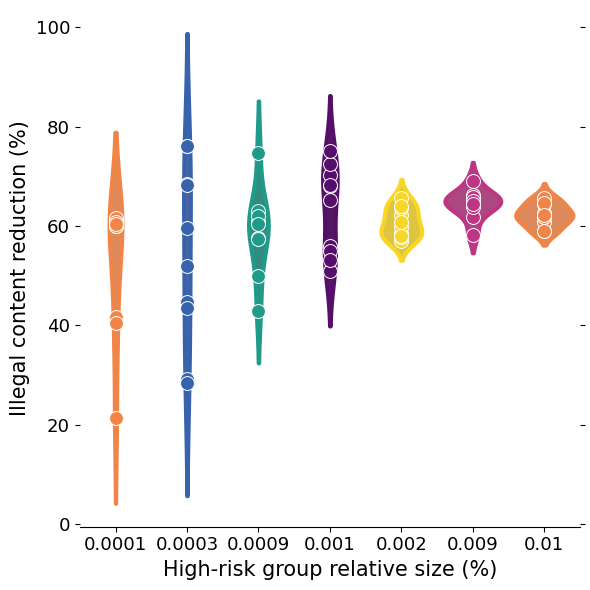

In [72]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"pct_change_illegal_prob_tau2")

plot_data = focal
fig, ax = plt.subplots(figsize=(6, 6))

# Get unique probabilities and sort them
probs = sorted(focal.illegal_prob.unique())

# Create the violin plot
violin = sns.violinplot(
    data=plot_data,
    x="illegal_content_probability",
    y="pct_change",
    order=probs,
    inner="point",
    palette=BLUEPALETTE,
)

violin.set_ylabel("Illegal content reduction (%)")
violin.set_xlabel("High-risk group relative size (%)")
patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
point_violinplot(ax, palette=BLUEPALETTE, n=len(probs), pointsize=100, linewidth=0.7)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
sns.despine(top=True, left=True, bottom=False)

# ax.set_ylim(0, 100)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf", dpi=300)
    fig.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Save tau=2 data to an object

In [73]:
tau2_res = plot_data

## Filter tau=8

In [74]:
focal = results[results.half_life == 8]
for pair in pairs:
    pop1 = focal[focal.illegal_prob == pair[0]]["pct_change"]
    pop2 = focal[focal.illegal_prob == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

In [75]:
df

,pair,U,p
0,"(0.0001, 0.0003)",46.0,0.795936
1,"(0.0001, 0.0009)",33.0,0.217563
2,"(0.0001, 0.001)",28.0,0.105122
3,"(0.0001, 0.002)",37.0,0.352681
4,"(0.0001, 0.009)",7.0,0.000487
5,"(0.0001, 0.01)",15.0,0.006841
6,"(0.0003, 0.0009)",46.0,0.795936
7,"(0.0003, 0.001)",38.0,0.393048
8,"(0.0003, 0.002)",44.0,0.684211
9,"(0.0003, 0.009)",39.0,0.435872


In [76]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(0.0001, 0.0003)",46.0,0.795936,1.000000
1,"(0.0001, 0.0009)",33.0,0.217563,1.000000
2,"(0.0001, 0.001)",28.0,0.105122,1.000000
3,"(0.0001, 0.002)",37.0,0.352681,1.000000
4,"(0.0001, 0.009)",7.0,0.000487,0.010230
5,"(0.0001, 0.01)",15.0,0.006841,0.143671
6,"(0.0003, 0.0009)",46.0,0.795936,1.000000
7,"(0.0003, 0.001)",38.0,0.393048,1.000000
8,"(0.0003, 0.002)",44.0,0.684211,1.000000
9,"(0.0003, 0.009)",39.0,0.435872,1.000000


# Plot pctchange 

pctchange = treatment - avg_control/avg_control


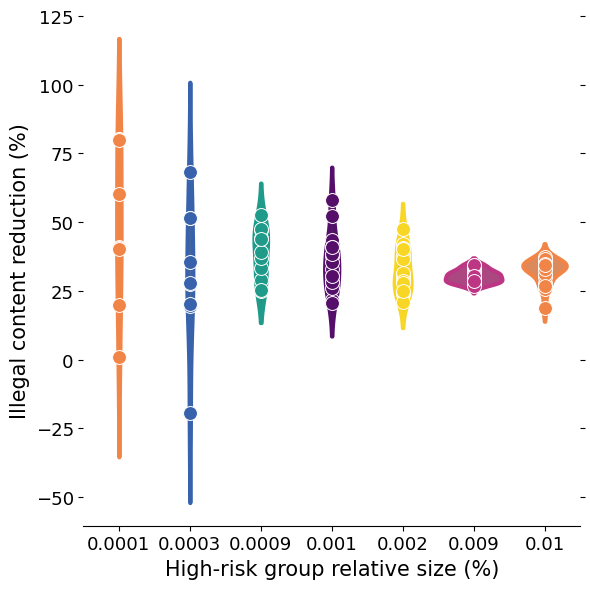

In [77]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"pct_change_illegal_prob_tau8")

plot_data = focal
fig, ax = plt.subplots(figsize=(6, 6))

# Get unique probabilities and sort them
probs = sorted(focal.illegal_prob.unique())

# Create the violin plot
violin = sns.violinplot(
    data=plot_data,
    x="illegal_content_probability",
    y="pct_change",
    order=probs,
    inner="point",
    palette=BLUEPALETTE,
)

violin.set_ylabel("Illegal content reduction (%)")
violin.set_xlabel("High-risk group relative size (%)")
patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
point_violinplot(ax, palette=BLUEPALETTE, n=len(probs), pointsize=100, linewidth=0.7)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
sns.despine(top=True, left=True, bottom=False)

# ax.set_ylim(0, 100)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf", dpi=300)
    fig.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Save tau=8 data to an object

In [78]:
tau8_res = plot_data

In [79]:
tau8_res

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,illegal_content_probability,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,pct_change
167,0.000805,0.000729,182,28,0.0010,8.0,0.0010,0.001048,0.001046,0.000325,0.000130,0.0010,30.322096
168,0.006779,0.006190,1531,238,0.0090,8.0,0.0090,0.009118,0.008938,0.000675,0.000553,0.0090,30.747616
170,0.000239,0.000234,54,9,0.0003,8.0,0.0003,0.000304,0.000322,0.000112,0.000070,0.0003,27.483688
173,0.009619,0.007513,2170,286,0.0100,8.0,0.0100,0.010575,0.010435,0.000971,0.000594,0.0100,27.995035
176,0.007141,0.006373,1611,244,0.0090,8.0,0.0090,0.009118,0.008938,0.000675,0.000553,0.0090,28.697641
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.000726,0.000499,164,19,0.0010,8.0,0.0010,0.001048,0.001046,0.000325,0.000130,0.0010,52.300069
360,0.007494,0.006396,1693,246,0.0090,8.0,0.0090,0.009118,0.008938,0.000675,0.000553,0.0090,28.438416
362,0.000956,0.000511,216,20,0.0009,8.0,0.0009,0.000900,0.000913,0.000227,0.000170,0.0009,44.034437
363,0.000221,0.000232,50,9,0.0003,8.0,0.0003,0.000304,0.000322,0.000112,0.000070,0.0003,27.927253


In [80]:
tau8_res[tau8_res['illegal_content_probability']==0.0003]['pct_change']

170    27.483688
190    51.658303
212    19.587108
248   -19.516659
259    68.428858
281    20.211586
312    35.361453
355    51.470541
363    27.927253
Name: pct_change, dtype: float64

## Remove outlier. Check this again

In [81]:
tau8_res = tau8_res[tau8_res['pct_change']>0]

# Plot in panel

In [82]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

plt.style.use("stylesheet.mplstyle")
PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
fpath = os.path.join(PLOT_DIR, f"pct_change_illegal_prob_combine")

Probs:  [0.0003, 0.0009, 0.001, 0.002, 0.009, 0.01]
p-values:                 pair     U         p  corrected_p
0   (0.0003, 0.0009)  46.0  0.795936     1.000000
1    (0.0003, 0.001)  38.0  0.393048     1.000000
2    (0.0003, 0.002)  44.0  0.684211     1.000000
3    (0.0003, 0.009)  39.0  0.435872     1.000000
4     (0.0003, 0.01)  42.0  0.578742     1.000000
5    (0.0009, 0.001)  37.0  0.352681     1.000000
6    (0.0009, 0.002)  41.0  0.528849     1.000000
7    (0.0009, 0.009)  17.0  0.011496     0.172444
8     (0.0009, 0.01)  27.0  0.089210     1.000000
9     (0.001, 0.002)  59.0  0.528849     1.000000
10    (0.001, 0.009)  54.0  0.795936     1.000000
11     (0.001, 0.01)  59.0  0.528849     1.000000
12    (0.002, 0.009)  16.0  0.008931     0.133960
13     (0.002, 0.01)  33.0  0.217563     1.000000
14     (0.009, 0.01)  75.0  0.063013     0.945193
Significant pairs (p<0.001):  []
Min p-val: 0.13396046677780424
p-values:                 pair      U         p  corrected_p
0   (0.0003, 

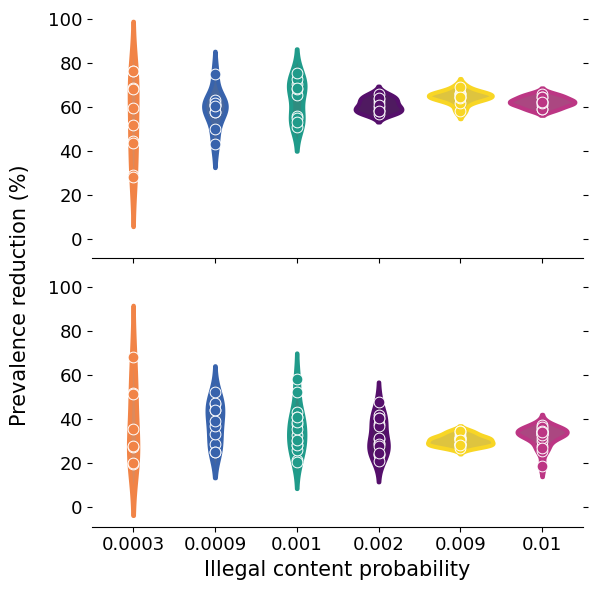

In [83]:
sig_level=0.001
plot_dfs = [tau2_res, tau8_res]
y_label = "Prevalence reduction (%)"

fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)

# Get unique probabilities and sort them
probs = sorted(plot_dfs[0].illegal_content_probability.unique())
probs.remove(0.0001)
print("Probs: ", probs)
for idx, plot_data in enumerate(plot_dfs):
    # print(f"** Plot {y_labels[idx]} **")
    ax = axs[idx]
    # Create the violin plot
    violin = sns.violinplot(
        ax=ax,
        data=plot_data,
        x="illegal_content_probability",
        y="pct_change",
        order=probs,
        inner="point",
        palette=BLUEPALETTE,
    )
    if idx == len(plot_dfs) - 1:
        violin.set_xlabel("Illegal content probability")
    else:
        violin.set_xlabel("")
    violin.set_ylabel('')

    patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
    point_violinplot(ax, palette=BLUEPALETTE, n=len(probs), pointsize=60, linewidth=0.7)
    ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
    sns.despine(top=True, left=True, bottom=False)

    ## TEST SIGNIFICANCE
    stats, significant_pairs = get_corrected_p(plot_data, focal_col="illegal_content_probability", sig_level=sig_level, values=probs)
    significant_pairs = [
        i for i in significant_pairs if i[0] in probs and i[1] in probs
    ]
    # Add annotations for significant pairs
    y_max = plot_data["pct_change"].max()
    for x1, x2 in significant_pairs:
        stat, p = stats[stats["pair"] == (x1, x2)][["U", "corrected_p"]].values[0]
        if p < sig_level:
            y = y_max + 5  # Adjust the y position for the annotation
            add_annotation(ax, probs.index(x1), probs.index(x2), y, get_annotation(p))
            print(f"Pair ( {x1}, {x2} ): p-value: {p:.2e}")
            y_max += 10  # Increment y_max for the next annotation

    # ax.set_ylim(0, 100)
fig.supylabel(y_label, fontsize=15)
# Saving
plt.tight_layout()

if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()